In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import random
import datetime as dt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import statsmodels.stats.api as sms
from scipy import stats
import collections
from collections import Counter
from scipy.stats import spearmanr, pearsonr
import pingouin as pg #repeated measure correlation
#plot
from matplotlib.colors import DivergingNorm
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import is_day
import config_origins_chapter0 as config

2


C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
#choose method to run the script on
name_method = 'ML-method'
#name_method = 'TD-method'

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#initialise parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
pal_ = config.pal_
pal_zone = config.pal_zone
pal_pens = config.pal_pens
dico_pen_ts = config.dico_pen_ts
pal_tracking_system = config.pal_tracking_system
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
path_extracted_data_cleaning_model = os.path.join(path_extracted_data_cleaning,'model')  
path_extracted_data_cleaning_rawvscleaned = os.path.join(path_extracted_data_cleaning,'Raw&Cleaned')  
path_extracted_data_cleaning_rawvscleaned_MLP = os.path.join(path_extracted_data_cleaning_rawvscleaned, 'MLP')
if not os.path.exists(path_extracted_data_cleaning_rawvscleaned_MLP):
    os.makedirs(path_extracted_data_cleaning_rawvscleaned_MLP)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [5]:
df_var = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_daily_ALL_variables.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_var.shape)
df_var['tracking_system'] = df_var['PenID'].map(lambda x: dico_pen_ts[x])
df_var['PenID'] = df_var['PenID'].map(lambda x: 'Pen '+str(int(x)))
#keep days with same artificial light (not that due to technical issue, sometimes we loose few hours on specific days for 
#some animals, thus we will remove these)
df_var = df_var[df_var['verification_daily_total_duration']==54000]
#remove the two dates with irregular WG openeing schedule:
li_date2remove = [dt.datetime(2021,1,4), dt.datetime(2020,11,13)] #first one already not here due to health assessment
df_var = df_var[~df_var['level'].isin(li_date2remove)]
#keep hens with at least 54 days (55 drop from 140 to 90)
df_henselection = df_var.groupby('HenID')['level'].agg(lambda x: len(set(x))).reset_index() #set as cleaning & raw
df_henselection['has_more_50_days'] = df_henselection['level'].map(lambda x: x>=54)
df_henselection['has_more_50_days'].value_counts()
li_hen_2keep = df_henselection[df_henselection['has_more_50_days']]['HenID'].unique()
df_var = df_var[df_var['HenID'].isin(li_hen_2keep)]
print(df_var.shape)
print('You are analysing %d days, starting at: %s until: %s, with %d hens'%(len(df_var['level'].unique()), 
                                                              str(df_var['level'].min()), 
                                                              str(df_var['level'].max()),
                                                              len(df_var['HenID'].unique())))
df_var.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19992, 132)
(15466, 133)
You are analysing 56 days, starting at: 2020-11-14 00:00:00 until: 2021-01-11 00:00:00, with 140 hens


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,temperature_night20_2_median,temperature_night20_2_max,temperature_night20_2_var,list_of_MovementCounter_day,len_MovementCounter_day,MovementCounter_day_amount_nnactivity,MovementCounter_day_max,MovementCounter_day_mean,type,tracking_system
1,hen_131,2020-11-14,405.0,17084.0,23716.0,2512.0,10283.0,54000.0,"[405.0, 17084.0, 23716.0, 2512.0, 10283.0]","[0.0075, 0.31637037037037036, 0.43918518518518...",...,26.0,28.0,0.750000,"[14.0, 69.0, 47.0, 79.0, 50.0, 46.0, 64.0, 75....",90.0,0.011111,95.0,59.077778,cleaning,TrackingSystem 10-12
2,hen_131,2020-11-15,0.0,16576.0,28684.0,2187.0,6553.0,54000.0,"[0.0, 16576.0, 28684.0, 2187.0, 6553.0]","[0.0, 0.30696296296296294, 0.5311851851851852,...",...,28.0,29.0,0.098765,"[16.0, 70.0, 57.0, 55.0, 60.0, 65.0, 73.0, 73....",90.0,0.033333,91.0,57.922222,cleaning,TrackingSystem 10-12
3,hen_131,2020-11-16,0.0,14508.0,29621.0,3091.0,6780.0,54000.0,"[0.0, 14508.0, 29621.0, 3091.0, 6780.0]","[0.0, 0.26866666666666666, 0.548537037037037, ...",...,27.0,28.0,0.693673,"[64.0, 23.0, 75.0, 52.0, 75.0, 48.0, 52.0, 58....",90.0,0.022222,94.0,54.944444,cleaning,TrackingSystem 10-12


In [6]:
#number of animals per pen
df_var.groupby('PenID')['HenID'].agg(lambda x: len(set(x)))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PenID
Pen 10    18
Pen 11    18
Pen 12    17
Pen 3     18
Pen 4     18
Pen 5     17
Pen 8     16
Pen 9     18
Name: HenID, dtype: int64

In [7]:
np.nanmean(df_var['Total_number_transition'].tolist()), np.nanmedian(df_var['Total_number_transition'].tolist())

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(66.48092590197854, 65.0)

# Initial visuals

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


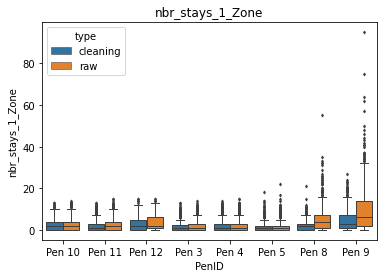

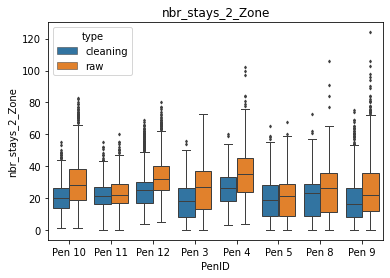

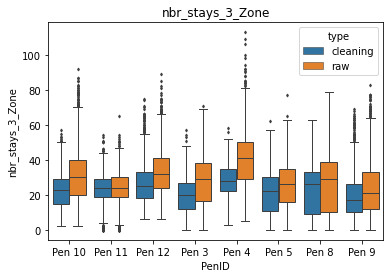

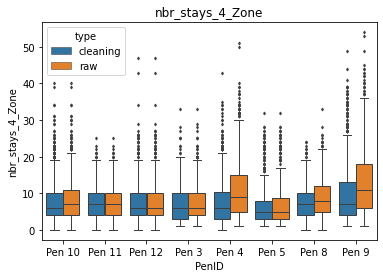

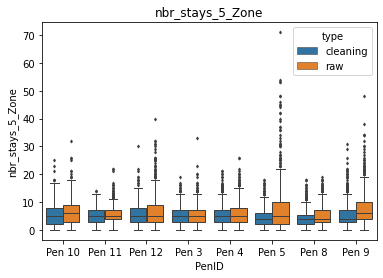

In [8]:
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
for v in li_var:
    sns.boxplot(x='PenID', y=v, hue='type', data=df_var, fliersize=2, linewidth=1)
    plt.title(v)
    plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_perPen_'+v+".png"),
            dpi=300,format='png',bbox_inches='tight')
    plt.show()

# Humidity and Temperature

(7293, 13)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather
0,2020-09-29 00:00:00,"10 °C\n(12:00 am CEST | Tuesday, September 29,...",average: 100% (100%)\n(12:00 am CEST | Tuesday...,"2 m/s\n(12:00 am CEST | Tuesday, September 29,...","rain\n(12:00 am CEST | Tuesday, September 29, ...","Moon Phase calculatorSeptember 29, 2020 0h",| waxing gibbous moon\n91.87% illuminated,0,10,2,100,rain,2020-09-29 00:00:00
1,2020-09-29 01:00:00,"10 °C\n(1:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(1:00 am CEST | Tuesday,...","3 m/s\n(1:00 am CEST | Tuesday, September 29, ...","rain\n(1:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 1h",| waxing gibbous moon\n92.09% illuminated,1,10,3,100,rain,2020-09-29 01:00:00
2,2020-09-29 02:00:00,"10 °C\n(2:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(2:00 am CEST | Tuesday,...","3 m/s\n(2:00 am CEST | Tuesday, September 29, ...","rain\n(2:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 2h",| waxing gibbous moon\n92.30% illuminated,2,10,3,100,rain,2020-09-29 02:00:00


(1586818, 7)


,HenID,PenID,system,Zone,prediction,Timestamp,date
0,hen_19,pen9,8 - 9,4_Zone,1,2020-11-13 00:12:06,2020-11-13
1,hen_19,pen9,8 - 9,5_Zone,1,2020-11-13 00:12:27,2020-11-13
2,hen_19,pen9,8 - 9,4_Zone,0,2020-11-13 00:13:30,2020-11-13


2020-11-13 00:12:06 2021-01-11 23:58:59


,HenID,PenID,system,Zone,prediction,Timestamp,date,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather,is_day
1586815,hen_101,pen5,3 - 5,5_Zone,1,2021-01-11 23:58:54,2021-01-11,"-7 °C\n(11:00 pm CET | Monday, January 11, 2021)",average: 96% (92 to 100%)\n(11:00 pm CET | Mon...,"1 m/s\n(11:00 pm CET | Monday, January 11, 2021)","no precipitation\n(11:00 pm CET | Monday, Janu...","Moon Phase calculatorJanuary 11, 2021 23h",| waning crescent moon\n2.18% illuminated,23,-7,1,96,no precipitation,2021-01-11 23:00:00,False
1586816,hen_124,pen8,8 - 9,3_Zone,1,2021-01-11 23:58:56,2021-01-11,"-7 °C\n(11:00 pm CET | Monday, January 11, 2021)",average: 96% (92 to 100%)\n(11:00 pm CET | Mon...,"1 m/s\n(11:00 pm CET | Monday, January 11, 2021)","no precipitation\n(11:00 pm CET | Monday, Janu...","Moon Phase calculatorJanuary 11, 2021 23h",| waning crescent moon\n2.18% illuminated,23,-7,1,96,no precipitation,2021-01-11 23:00:00,False
1586817,hen_124,pen8,8 - 9,2_Zone,1,2021-01-11 23:58:59,2021-01-11,"-7 °C\n(11:00 pm CET | Monday, January 11, 2021)",average: 96% (92 to 100%)\n(11:00 pm CET | Mon...,"1 m/s\n(11:00 pm CET | Monday, January 11, 2021)","no precipitation\n(11:00 pm CET | Monday, Janu...","Moon Phase calculatorJanuary 11, 2021 23h",| waning crescent moon\n2.18% illuminated,23,-7,1,96,no precipitation,2021-01-11 23:00:00,False


C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(0, 4)


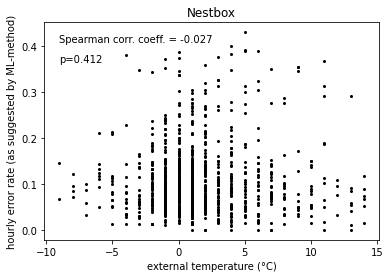

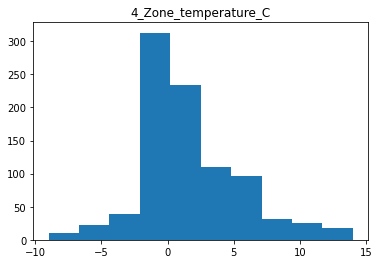

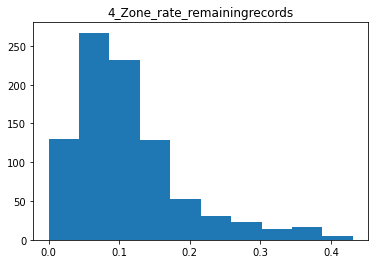

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(0, 4)


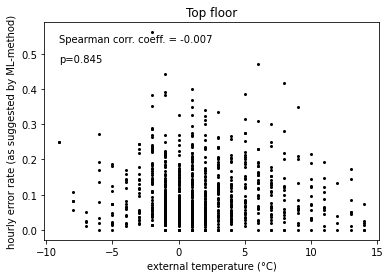

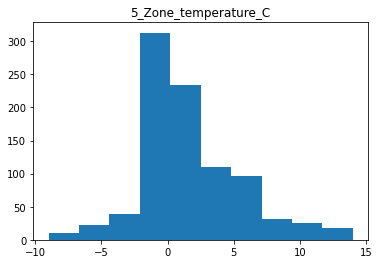

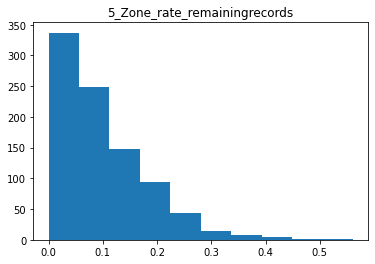

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(0, 4)


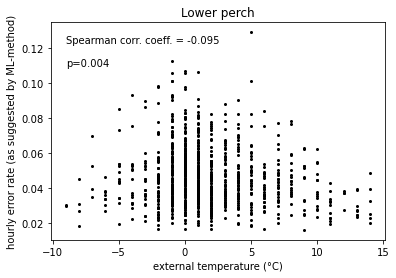

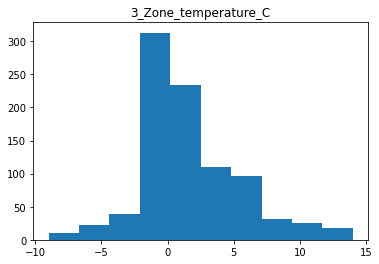

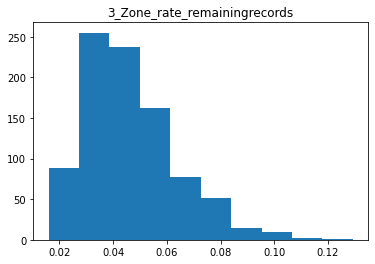

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(0, 4)


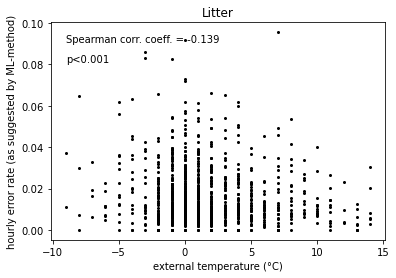

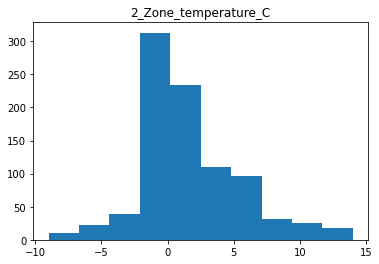

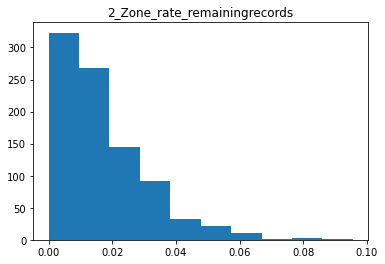

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(0, 4)


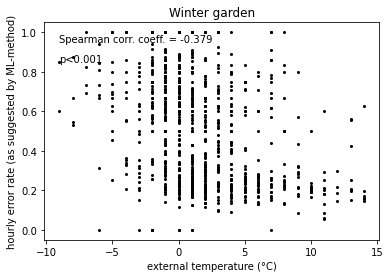

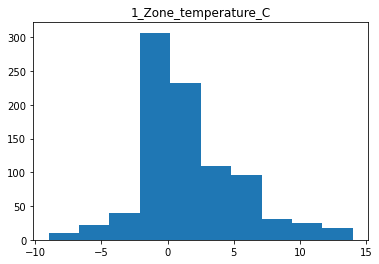

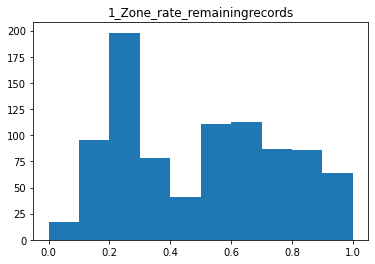

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(0, 4)


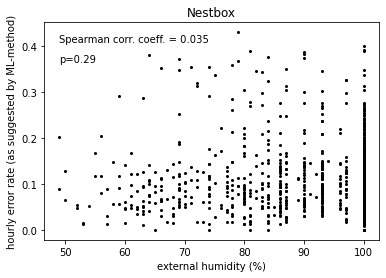

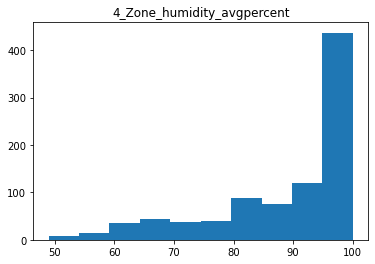

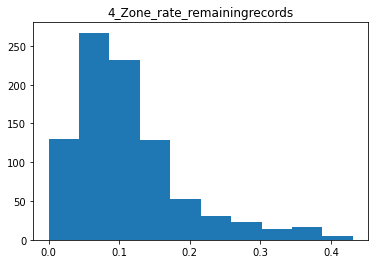

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(0, 4)


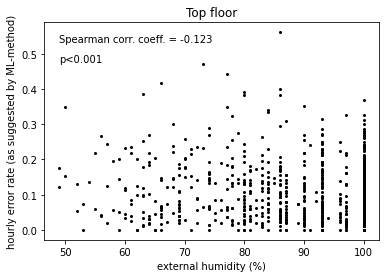

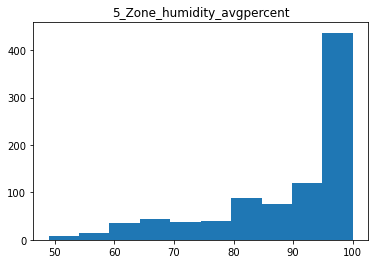

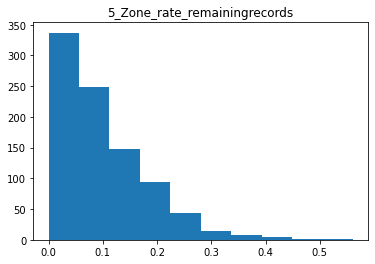

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(0, 4)


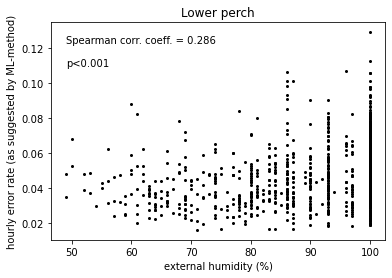

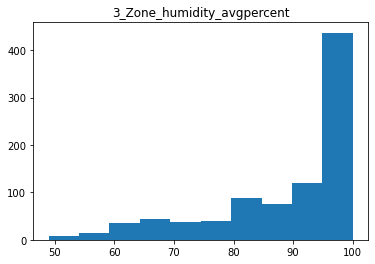

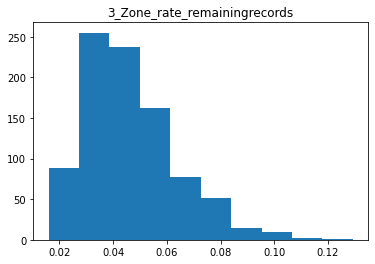

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(0, 4)


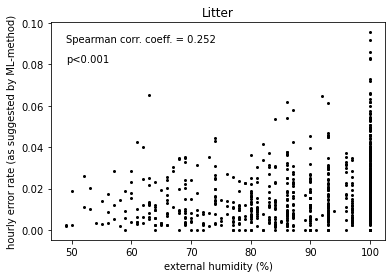

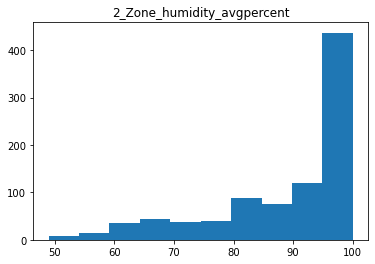

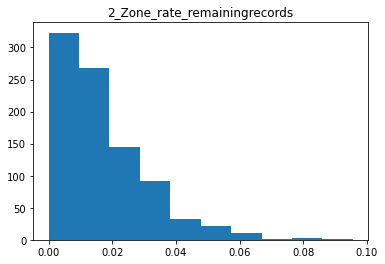

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


(0, 4)


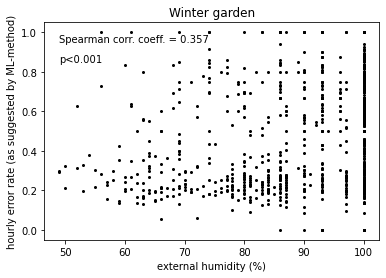

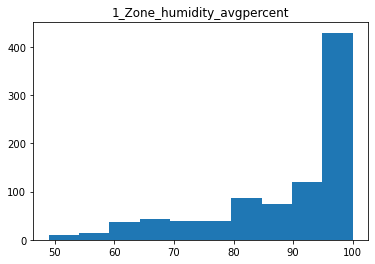

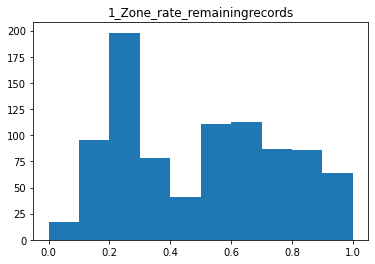

,zone,environtmental_factor,spearmanr_coeff,spearman_pval
0,4_Zone,temperature_C,-0.027,0.412
1,5_Zone,temperature_C,-0.007,0.845
2,3_Zone,temperature_C,-0.095,0.004
3,2_Zone,temperature_C,-0.139,0.000
4,1_Zone,temperature_C,-0.379,0.000
5,4_Zone,humidity_avgpercent,0.035,0.290
6,5_Zone,humidity_avgpercent,-0.123,0.000
7,3_Zone,humidity_avgpercent,0.286,0.000
8,2_Zone,humidity_avgpercent,0.252,0.000
9,1_Zone,humidity_avgpercent,0.357,0.000


In [9]:
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(3))

#prediction per records
df_pred = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, id_run+name_method+'_Rawdata&Model.csv'), sep=';', 
                 parse_dates=['Timestamp','date'], dayfirst=True)
df_pred.rename(columns={'Trackingsystem_Zone':'Zone'}, inplace=True)
df_pred = df_pred.sort_values('Timestamp') 
print(df_pred.shape)
display(df_pred.head(3))
print(min(df_pred['Timestamp']), max(df_pred['Timestamp']))

#merge it to closest date
df_pred_weather = pd.merge_asof(df_pred, df_weather_h, on='Timestamp')
df_pred_weather['is_day'] = df_pred_weather['Timestamp'].map(lambda x: is_day(x, config.dico_night_hour))
display(df_pred_weather.tail(3))

li_weather_type = ['temperature_C', 'humidity_avgpercent']
dico_t_name = {'humidity_avgpercent':'external humidity (%)','temperature_C':'external temperature (°C)'}
li_df = []
#visuals
for weather_type in li_weather_type:
    for z in df_pred_weather['Zone'].unique():
        df_humidity_bias = df_pred_weather[(df_pred_weather['Zone']==z)&\
                                           (df_pred_weather['is_day'])].groupby(['Timestamp_weather'])[['prediction',weather_type]].agg(lambda x: list(x)).reset_index()
        df_humidity_bias['rate_remainingrecords'] = df_humidity_bias['prediction'].map(lambda x: Counter(list(x))[0]/len(x))
        df_humidity_bias[weather_type] = df_humidity_bias[weather_type].map(lambda x: list(set(x)))
        df_humidity_bias[weather_type] = df_humidity_bias[weather_type].map(lambda x: x[0] if len(x)==1 else 'error')
        print(df_humidity_bias[df_humidity_bias[weather_type]=='error'].shape)
        #display(df_humidity_bias.head(3))

        #bias toward higher humidity?
        #ax = sns.regplot(weather_type,'rate_remainingrecords', data=df_humidity_bias, color='grey');
        plt.scatter(df_humidity_bias[weather_type], df_humidity_bias['rate_remainingrecords'],color='black', s=4)
        coeff,pval = spearmanr(df_humidity_bias[weather_type].tolist(), df_humidity_bias['rate_remainingrecords'].tolist())
        li_df.append({'zone':z, 'environtmental_factor':weather_type, 'spearmanr_coeff':np.round(coeff,3), 'spearman_pval':np.round(pval,3)})
        ma_y = max(df_humidity_bias['rate_remainingrecords'])
        mi_x = min(df_humidity_bias[weather_type])
        ma_x = min(df_humidity_bias[weather_type])
        plt.text(mi_x+abs(ma_x-mi_x)*0.05, ma_y*0.95, 'Spearman corr. coeff. = ' + str(np.round(coeff,3)))
        if pval<0.001:
            plt.text(mi_x+abs(ma_x-mi_x)*0.05, ma_y*0.85, 'p<0.001')
        else:
            plt.text(mi_x+abs(ma_x-mi_x)*0.05, ma_y*0.85, 'p=' + str(np.round(pval,3)))
        plt.title(config.dico_zone_plot_name[z])
        #plt.ylim(0,1.1)
        plt.ylabel('hourly error rate (as suggested by ML-method)')
        plt.xlabel(dico_t_name[weather_type])
        plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_'+z+"_"+weather_type+".png"),
                    dpi=300,format='png',bbox_inches='tight')
        plt.show()
        plt.hist(df_humidity_bias[weather_type].tolist());
        plt.title(z+'_'+weather_type)
        plt.show()
        plt.hist(df_humidity_bias['rate_remainingrecords'].tolist());
        plt.title(z+'_rate_remainingrecords')
        plt.show()
df_envfactors = pd.DataFrame(li_df)
df_envfactors

# Dataframe for Cleaning effect

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,level,type,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
1,hen_131,Pen 10,2020-11-14,cleaning,2.0,18.0,20.0,7.0,4.0
2,hen_131,Pen 10,2020-11-15,cleaning,0.0,12.0,16.0,7.0,4.0
3,hen_131,Pen 10,2020-11-16,cleaning,0.0,10.0,12.0,2.0,2.0


,level,HenID,PenID,type,Trackingsystem_Zone,nbr_of_stay
0,2020-11-14,hen_131,Pen 10,cleaning,nbr_stays_1_Zone,2.0
1,2020-11-15,hen_131,Pen 10,cleaning,nbr_stays_1_Zone,0.0
2,2020-11-16,hen_131,Pen 10,cleaning,nbr_stays_1_Zone,0.0


(2912, 9) (35753, 9)
(38665, 9)
(35753, 9)


type,level,HenID,PenID,Trackingsystem_Zone,cleaning,raw,Difference_r-cl,absolute_difference,diff_rate
0,2020-11-14,hen_1,Pen 9,nbr_stays_1_Zone,8.0,8.0,0.0,0.0,1.0
1,2020-11-14,hen_1,Pen 9,nbr_stays_2_Zone,17.0,17.0,0.0,0.0,1.0
2,2020-11-14,hen_1,Pen 9,nbr_stays_3_Zone,9.0,9.0,0.0,0.0,1.0


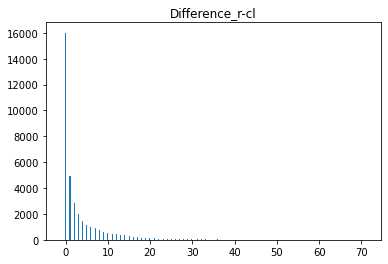

In [10]:
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
display(df_var[['HenID','PenID','level', 'type']+li_var].head(3))
#put all bouts into a columns
df_cleaning_effect = pd.melt(df_var, id_vars=['level', 'HenID', 'PenID', 'type'], value_vars=li_var)
df_cleaning_effect.rename(columns={'variable':'Trackingsystem_Zone', 'value':'nbr_of_stay'}, inplace=True)
display(df_cleaning_effect.head(3))
df_cleaning_effect = df_cleaning_effect.pivot(index=['level','HenID','PenID','Trackingsystem_Zone'], 
                      columns='type',values='nbr_of_stay').reset_index()
df_cleaning_effect['Difference_r-cl'] = df_cleaning_effect.apply(lambda x: x['raw']-x['cleaning'], axis=1)
df_cleaning_effect['absolute_difference'] = df_cleaning_effect['Difference_r-cl'].map(lambda x: abs(x))
#if the tracking system do not record any trnasitions in a zone over a day for a particular animal, then there is nothing to be
#compared, we will remove it simply
df_cleaning_effect['diff_rate'] = df_cleaning_effect.apply(lambda x: min(x['cleaning'],x['raw'])/max(x['cleaning'],x['raw']) if x['raw']!=0 else np.nan, axis=1)
print(df_cleaning_effect[df_cleaning_effect['diff_rate'].isnull()].shape, df_cleaning_effect[~df_cleaning_effect['diff_rate'].isnull()].shape)
#df_cleaning_effect['level_continuous'] = df_cleaning_effect['level'].map(lambda x: (x-df_cleaning_effect['level'].min()).days)
#display(df_cleaning_effect[df_cleaning_effect['Difference_r-cl']<0]) #checked manually: was correct: when the model remove the last transtion of the 
#night, then the bird will start his day / first stay in a different zone, which at the end can be adding a stay in this zone.
print(df_cleaning_effect.shape)
df_cleaning_effect = df_cleaning_effect[~df_cleaning_effect.isnull().any(axis=1)]
print(df_cleaning_effect.shape)
display(df_cleaning_effect.head(3))
#plot
plt.hist(df_cleaning_effect['Difference_r-cl'].dropna(),bins='auto');
plt.title('Difference_r-cl')
plt.show()

#save
li_modelVAR =  ['absolute_difference', 'diff_rate', 'PenID','Trackingsystem_Zone','HenID','level','humidity_avgpercent']
df_cleaning_effect.filter(li_modelVAR).to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,
                                               name_method+'_df4DifferenceModelling.csv'), index=False, sep=';')

### visual per pen

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


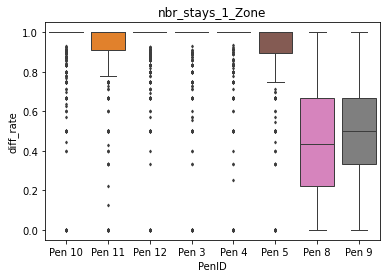

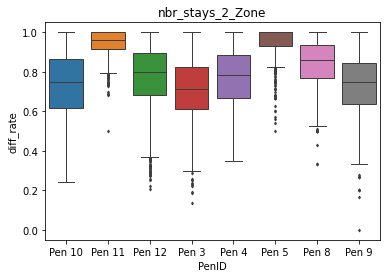

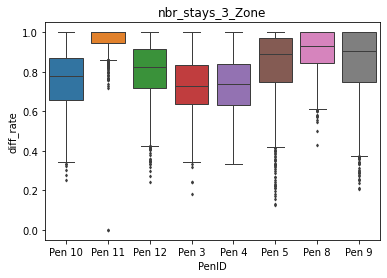

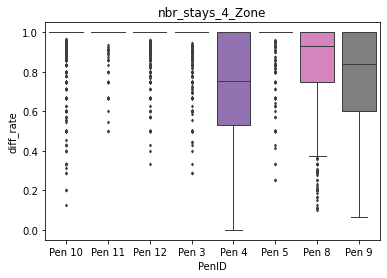

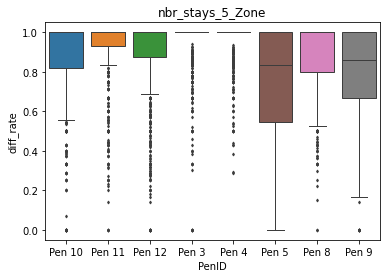

In [11]:
li_var = ['nbr_stays_1_Zone','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
for v in li_var:
    sns.boxplot(x='PenID', y='diff_rate', data=df_cleaning_effect[df_cleaning_effect['Trackingsystem_Zone']==v].sort_values('PenID'), 
                fliersize=2, linewidth=1)
    plt.title(v)
    plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_perPen_'+v+"_diffrate.png"),
            dpi=300,format='png',bbox_inches='tight')
    plt.show()

### Scatter plot: per zone, per pens OVER ENTIRE PERIOD

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


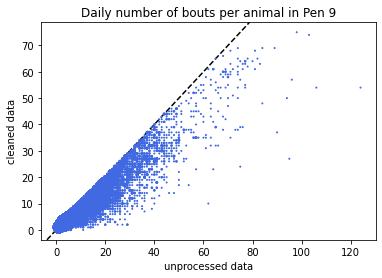

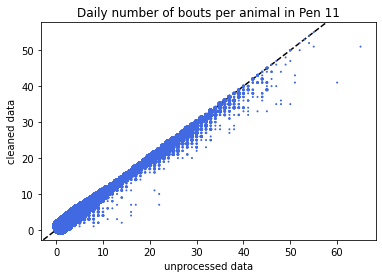

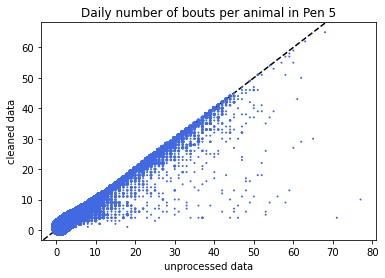

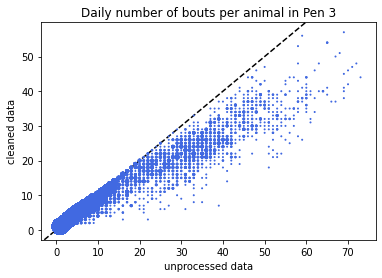

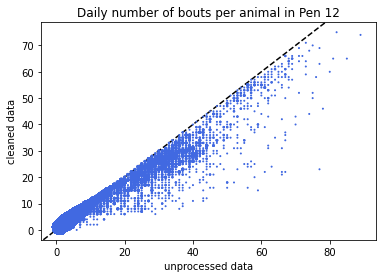

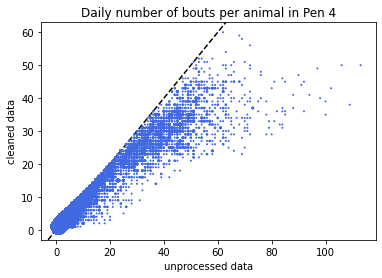

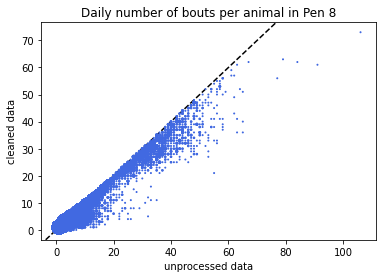

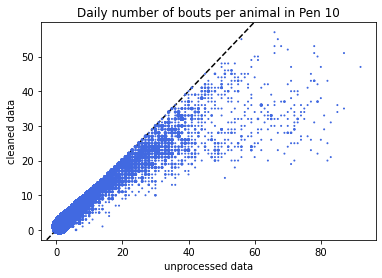

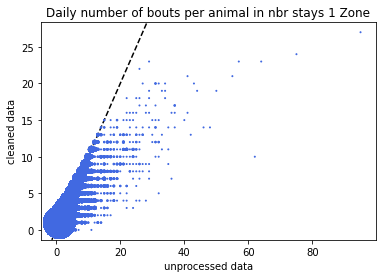

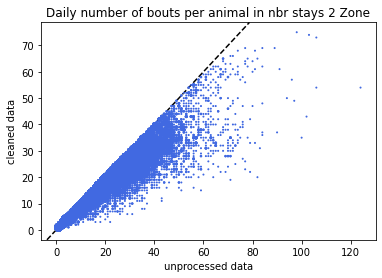

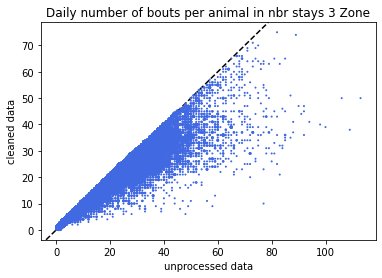

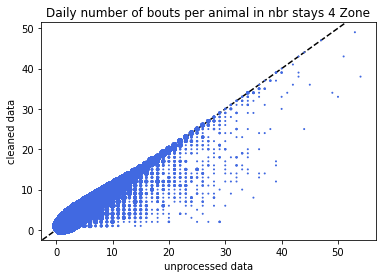

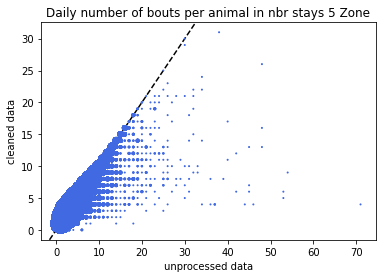

In [12]:
#visuals of the actual number of bouts per methods for curiosity/better understanding
for type_ in ['PenID','Trackingsystem_Zone']:
    for y_ in df_cleaning_effect[type_].unique():
        x = np.array(df_cleaning_effect[df_cleaning_effect[type_]==y_]['raw'].tolist())
        y = np.array(df_cleaning_effect[df_cleaning_effect[type_]==y_]['cleaning'].tolist())
        c = Counter(zip(x,y))
        # create a list of the sizes, here multiplied by 10 for scale
        s = [1*c[(xx,yy)] for xx,yy in zip(x,y)]
        plt.scatter(x, y, s=s, color = 'royalblue')
        plt.xlabel('unprocessed data')
        plt.ylabel('cleaned data')
        plt.title('Daily number of bouts per animal in '+y_.replace('_',' '))
        #add diagonal line
        plt.axline((0, 0), slope=1, c="black", ls="--", zorder=0)
        #save and show
        plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+"_NbrStay_"+y_+".png"),
                    dpi=300,format='png',bbox_inches='tight')
        plt.show();

# EV per zones, per pens

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


type,PenID,Trackingsystem_Zone,HenID,cleaning,raw,CEV
0,Pen 10,nbr_stays_1_Zone,hen_131,"[2.0, 1.0, 3.0, 3.0, 2.0, 2.0, 3.0, 5.0, 4.0, ...","[3.0, 1.0, 3.0, 3.0, 2.0, 2.0, 3.0, 5.0, 4.0, ...",0.945877
1,Pen 10,nbr_stays_1_Zone,hen_134,"[9.0, 6.0, 8.0, 4.0, 6.0, 7.0, 8.0, 8.0, 12.0,...","[10.0, 6.0, 9.0, 4.0, 6.0, 7.0, 8.0, 8.0, 13.0...",0.898902
2,Pen 10,nbr_stays_1_Zone,hen_138,"[7.0, 8.0, 10.0, 11.0, 13.0, 9.0, 8.0, 11.0, 1...","[8.0, 10.0, 10.0, 12.0, 14.0, 9.0, 10.0, 12.0,...",0.940469


,PenID,Trackingsystem_Zone,CEV,stddev,mean,annot
0,Pen 10,nbr_stays_1_Zone,"[0.945877224845623, 0.8989024522765965, 0.9404...",0.517009,0.746053,0.75 \n +/-0.52
1,Pen 10,nbr_stays_2_Zone,"[0.7485326464459365, 0.09011695906432748, 0.26...",0.205070,0.491572,0.49 \n +/-0.21
2,Pen 10,nbr_stays_3_Zone,"[0.7415587949672917, 0.603350234324499, 0.5186...",0.186651,0.567248,0.57 \n +/-0.19


annotations:


Trackingsystem_Zone,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
PenID,,,,,
Pen 10,0.75 \n +/-0.52,0.49 \n +/-0.21,0.57 \n +/-0.19,0.94 \n +/-0.12,0.62 \n +/-0.22
Pen 11,0.84 \n +/-0.12,0.87 \n +/-0.23,0.92 \n +/-0.09,0.98 \n +/-0.06,0.75 \n +/-0.18
Pen 12,0.85 \n +/-0.23,0.59 \n +/-0.2,0.64 \n +/-0.16,0.96 \n +/-0.05,0.57 \n +/-0.26
Pen 3,0.75 \n +/-0.42,0.55 \n +/-0.2,0.58 \n +/-0.18,0.93 \n +/-0.11,0.66 \n +/-0.56
Pen 4,0.83 \n +/-0.24,0.49 \n +/-0.19,0.52 \n +/-0.17,0.6 \n +/-0.28,0.89 \n +/-0.14
Pen 5,0.88 \n +/-0.14,0.94 \n +/-0.07,0.61 \n +/-0.31,0.95 \n +/-0.09,0.36 \n +/-0.2
Pen 8,0.49 \n +/-0.19,0.77 \n +/-0.14,0.82 \n +/-0.14,0.76 \n +/-0.23,0.82 \n +/-0.15
Pen 9,0.57 \n +/-0.13,0.73 \n +/-0.12,0.8 \n +/-0.19,0.64 \n +/-0.26,0.57 \n +/-0.19


values:


Trackingsystem_Zone,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
PenID,,,,,
Pen 10,0.746053,0.491572,0.567248,0.939271,0.620257
Pen 11,0.838405,0.866386,0.915104,0.983631,0.749358
Pen 12,0.846765,0.585042,0.642860,0.962595,0.574455
Pen 3,0.750367,0.547753,0.575388,0.926831,0.662478
Pen 4,0.834498,0.487849,0.516458,0.598056,0.888648
Pen 5,0.878944,0.941737,0.608822,0.951573,0.358033
Pen 8,0.493374,0.767055,0.824403,0.756380,0.816311
Pen 9,0.571580,0.732819,0.804222,0.643600,0.565747


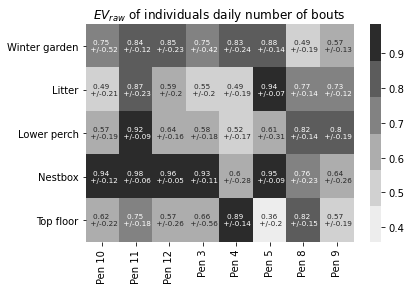

In [13]:
#computing per animal and taking the mean +-std deviation
df_quantitatif = df_cleaning_effect.groupby(['PenID','Trackingsystem_Zone','HenID'])[['cleaning','raw']].agg(lambda x: list(x)).reset_index()
df_quantitatif['CEV'] = df_quantitatif.apply(lambda x: explained_variance_score(x['raw'], x['cleaning']), axis=1)
display(df_quantitatif.head(3))
df_quantitatif = df_quantitatif.groupby(['PenID','Trackingsystem_Zone'])['CEV'].agg(lambda x: list(x)).reset_index()
df_quantitatif['stddev'] = df_quantitatif['CEV'].map(lambda x: np.std(x)) #not IC as not normally distrib.
df_quantitatif['mean'] = df_quantitatif['CEV'].map(lambda x: np.mean(x))
df_quantitatif['annot'] = df_quantitatif.apply(lambda x: str(round(x['mean'],2))+' \n +/-'+str(round(x['stddev'],2)), axis=1)
display(df_quantitatif.head(3))
#annotations
df_annot = df_quantitatif.pivot(values='annot',index='PenID',columns='Trackingsystem_Zone')
print('annotations:')
display(df_annot)
annot_mean_std = df_annot.to_numpy()
#values
df_quantitatif = df_quantitatif.pivot(values='mean',index='PenID',columns='Trackingsystem_Zone')
print('values:')
display(df_quantitatif)
M = df_quantitatif.to_numpy()
dico_x_name = {'nbr_stays_1_Zone':'Winter garden',
             'nbr_stays_2_Zone':'Litter',
             'nbr_stays_3_Zone':'Lower perch',
             'nbr_stays_4_Zone':'Nestbox',
             'nbr_stays_5_Zone':'Top floor'}
sns.heatmap(M.transpose(), xticklabels=df_quantitatif.index.tolist(), 
            yticklabels=[dico_x_name[x] for x in df_quantitatif.columns.tolist()], cmap=sns.color_palette("Greys"),
            annot=annot_mean_std.transpose(), fmt='', annot_kws={"size":7.3})
plt.title(r'$EV_{raw}$ of individuals daily number of bouts')
plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_CEV_ZonePerPen.png'),format='png',dpi=300,
           bbox_inches='tight')
plt.show()

# EV per hens, active hens influence

In [14]:
df_quantitatif_hen = df_cleaning_effect.groupby(['HenID','PenID'])[['cleaning','raw']].agg(lambda x: list(x)).reset_index()
df_quantitatif_hen['EV'] = df_quantitatif_hen.apply(lambda x: explained_variance_score(x['raw'], x['cleaning']), axis=1)
df_quantitatif_hen['average number of bouts in a zone'] = df_quantitatif_hen['cleaning'].map(lambda x: np.mean(x))
df_quantitatif_hen

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


type,HenID,PenID,cleaning,raw,EV,average number of bouts in a zone
0,hen_1,Pen 9,"[8.0, 17.0, 9.0, 4.0, 5.0, 4.0, 13.0, 9.0, 2.0...","[8.0, 17.0, 9.0, 4.0, 5.0, 7.0, 17.0, 10.0, 2....",0.663893,12.035714
1,hen_10,Pen 11,"[2.0, 13.0, 13.0, 4.0, 3.0, 3.0, 16.0, 15.0, 5...","[2.0, 13.0, 13.0, 4.0, 3.0, 3.0, 16.0, 15.0, 5...",0.974926,11.233202
2,hen_101,Pen 5,"[7.0, 15.0, 14.0, 8.0, 10.0, 16.0, 11.0, 7.0, ...","[7.0, 16.0, 14.0, 9.0, 11.0, 18.0, 11.0, 8.0, ...",0.965716,14.917323
3,hen_102,Pen 3,"[3.0, 5.0, 7.0, 9.0, 6.0, 1.0, 3.0, 5.0, 6.0, ...","[3.0, 7.0, 9.0, 9.0, 6.0, 1.0, 3.0, 5.0, 6.0, ...",0.937334,9.118519
4,hen_105,Pen 9,"[1.0, 8.0, 10.0, 5.0, 5.0, 4.0, 7.0, 7.0, 6.0,...","[2.0, 9.0, 14.0, 9.0, 5.0, 6.0, 8.0, 8.0, 8.0,...",0.831345,10.163636
...,...,...,...,...,...,...
135,hen_95,Pen 11,"[3.0, 22.0, 24.0, 10.0, 5.0, 19.0, 24.0, 9.0, ...","[5.0, 24.0, 24.0, 10.0, 5.0, 19.0, 24.0, 9.0, ...",0.987551,12.494505
136,hen_96,Pen 3,"[9.0, 14.0, 6.0, 7.0, 8.0, 12.0, 4.0, 4.0, 7.0...","[12.0, 17.0, 7.0, 7.0, 9.0, 13.0, 5.0, 5.0, 8....",0.844631,9.612903
137,hen_97,Pen 3,"[3.0, 6.0, 7.0, 5.0, 6.0, 8.0, 7.0, 6.0, 4.0, ...","[4.0, 7.0, 7.0, 5.0, 6.0, 8.0, 7.0, 6.0, 5.0, ...",0.552048,8.709677
138,hen_98,Pen 9,"[0.0, 5.0, 6.0, 8.0, 8.0, 1.0, 6.0, 7.0, 6.0, ...","[1.0, 6.0, 6.0, 8.0, 8.0, 2.0, 8.0, 7.0, 6.0, ...",0.762065,6.924242


In [15]:
#extreme case verified : a lot of flickering
min(df_quantitatif_hen['EV']), max(df_quantitatif_hen['EV']), np.median(df_quantitatif_hen['EV'])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.15554978357861438, 0.9944736057366863, 0.8934240126887556)

In [16]:
df_quantitatif_hen[df_quantitatif_hen['EV']==min(df_quantitatif_hen['EV'])]
#df_cleaning_effect[df_cleaning_effect['HenID']=='hen_12'].iloc[0:50]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


type,HenID,PenID,cleaning,raw,EV,average number of bouts in a zone
16,hen_12,Pen 5,"[14.0, 33.0, 22.0, 7.0, 4.0, 8.0, 14.0, 9.0, 6...","[15.0, 34.0, 28.0, 7.0, 10.0, 9.0, 15.0, 23.0,...",0.15555,6.938224


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,r,dof,pval,CI95%,power
rm_corr,0.460793,131,2.388482e-08,"[0.32, 0.59]",0.999908


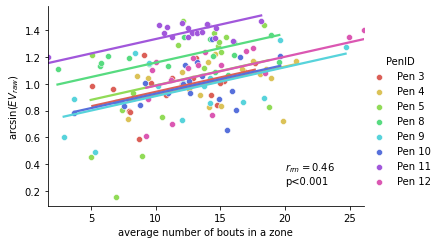

In [17]:
dico_pen_order = {'Pen 9':5, 'Pen 11':7, 'Pen 5':3, 'Pen 3':1, 'Pen 12':8, 'Pen 4':2, 'Pen 8':4, 'Pen 10':6}
df_quantitatif_hen['order'] = df_quantitatif_hen['PenID'].map(lambda x: dico_pen_order[x])
df_quantitatif_hen = df_quantitatif_hen.sort_values('order')
#arcsine transformation to improve normality
df_quantitatif_hen['EV_arcsin'] = df_quantitatif_hen['EV'].map(lambda x: np.arcsin(x))
#compute repeated measure correlation
rep_corr = pg.rm_corr(data=df_quantitatif_hen, x='average number of bouts in a zone', y='EV_arcsin', subject='PenID')
display(rep_corr)
#plot
pg.plot_rm_corr(data=df_quantitatif_hen, x='average number of bouts in a zone', y='EV_arcsin', subject='PenID', legend=True, 
                kwargs_facetgrid=dict(height=3.5, aspect=1.5));
plt.ylabel(r'$\arcsin(EV_{raw})$')
plt.xlabel('average number of bouts in a zone')
plt.text(20, 0.35, r'$r_{rm}=$' + str(np.round(rep_corr['r'].values[0],2)))
if rep_corr['pval'].values[0]<0.001:
    plt.text(20, 0.25, 'p<0.001')
else:
    plt.text(20, 0.25, 'p-value='+ str(np.round(rep_corr['pval'].values[0],2)))
plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+"_activehens_bias.png"),
            dpi=300, format='png', bbox_inches='tight')
plt.show()